### CCAE Analysis

In [48]:
#read in ccae data 
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/docs/ccae_1yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_1y = pd.read_pickle(file_path)

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/docs/ccae_3yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_3y = pd.read_pickle(file_path)

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/docs/ccae_10yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_10y = pd.read_pickle(file_path)

In [49]:
# Convert the series of tuples into dataframes

data_list = df_1y['endo_subject_id'].tolist()

expanded_data_1 = pd.DataFrame.from_records(data_list, columns=[
    'endo_subject_id', 'endo_birth_year', 'endo_visit_date', 
    'comp_subject_id', 'comp_birth_year', 'comp_visit_date', 'score'
])
expanded_data_1 = expanded_data_1.drop_duplicates(subset=['comp_subject_id'])

# Convert the series of tuples into a list
data_list = df_3y['endo_subject_id'].tolist()

expanded_data_3 = pd.DataFrame.from_records(data_list, columns=[
    'endo_subject_id', 'endo_birth_year', 'endo_visit_date', 
    'comp_subject_id', 'comp_birth_year', 'comp_visit_date', 'score'
])
expanded_data_3 = expanded_data_3.drop_duplicates(subset=['comp_subject_id'])

# Convert the series of tuples into a list
data_list = df_10y['endo_subject_id'].tolist()

expanded_data_10 = pd.DataFrame.from_records(data_list, columns=[
    'endo_subject_id', 'endo_birth_year', 'endo_visit_date', 
    'comp_subject_id', 'comp_birth_year', 'comp_visit_date', 'score'
])
expanded_data_10 = expanded_data_10.drop_duplicates(subset=['comp_subject_id'])

#only looking at 1 and 3 yr
data = [expanded_data_1, expanded_data_3]

In [50]:
print(expanded_data_1.shape)
print(expanded_data_3['comp_subject_id'].nunique())
print(expanded_data_3['endo_subject_id'].nunique())

(705781, 7)
311758
82748


In [51]:
# read in autoimmune CCAE data 

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/matches/autoimmune_cohorts_ccae.pkl'

# Read the pickle file into a pandas DataFrame
df = pd.read_pickle(file_path)

df.head()

,0
0,"[IMMUNE3, 28306416801, 2009-11-09, 2014-12-31]"
1,"[IMMUNE3, 323569301, 2009-03-10, 2011-05-31]"
2,"[IMMUNE3, 2492322401, 2012-01-03, 2014-10-31]"
3,"[IMMUNE3, 1588546701, 2011-10-05, 2017-12-31]"
4,"[IMMUNE3, 4332409202, 2016-11-30, 2017-12-31]"


In [52]:
data_list = df[0].tolist()

autoimmune_data = pd.DataFrame.from_records(data_list, columns=[
    'cohort_definition_id', 'subject_id', 'cohort_start_date', 
    'cohort_end_date'
])

autoimmune_data.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date
0,IMMUNE3,28306416801,2009-11-09,2014-12-31
1,IMMUNE3,323569301,2009-03-10,2011-05-31
2,IMMUNE3,2492322401,2012-01-03,2014-10-31
3,IMMUNE3,1588546701,2011-10-05,2017-12-31
4,IMMUNE3,4332409202,2016-11-30,2017-12-31


In [53]:
disease_map = {'IMMUNE1': 'Hashimotos', 'IMMUNE2': 'Graves', 'IMMUNE3': 'Rheumatoid Arthritis', 'IMMUNE4': 'Vitiligo',
               'IMMUNE5': 'Type 1 DM', 'IMMUNE6': 'Pernicious A', 'IMMUNE7': 'MS', 'IMMUNE8': 'SLE',
               'IMMUNE9': 'Sjorgens', 'IMMUNE10': 'Myositis'}

In [54]:
#calculate OR/CI for separately for all diseases in CCAE 1 and 3 year cohorts 
from scipy.stats import chi2_contingency
import scipy.stats
import numpy as np 

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Year', 'Disease', 'Odds Ratio', '95% CI (Low)', '95% CI (High)', '95% CI (Low) Bonferroni', '95% CI (High) Bonferroni', 'P-value'])

year = 1 
for expanded_data in data:
    endo_subject_ids = expanded_data['endo_subject_id'].unique()
    comp_subject_ids = expanded_data['comp_subject_id'].unique()
    endo_subject_ids_set = set(endo_subject_ids)
    comp_subject_ids_set = set(comp_subject_ids)

    unique_ids = endo_subject_ids_set.union(comp_subject_ids_set)
    unique_ids_list = list(unique_ids)
    #calculate OR/CI for all diseases
    for dis in list(disease_map.keys()): 
        dis_df = autoimmune_data[autoimmune_data['cohort_definition_id'] == dis]
        new_df = pd.DataFrame(unique_ids_list, columns=['subject_id'])
        new_df['endo'] = 0
        new_df['dis'] = 0

        endo_ids = expanded_data['endo_subject_id'].unique()
        new_df.loc[new_df['subject_id'].isin(endo_ids), 'endo'] = 1

        immune_start_date_map = dis_df.set_index('subject_id')['cohort_start_date'].to_dict()
        endo_visit_date_map = expanded_data.set_index('endo_subject_id')['endo_visit_date'].to_dict()

        new_df['dis_start_date'] = new_df['subject_id'].map(immune_start_date_map)
        new_df['endo_visit_date'] = new_df['subject_id'].map(endo_visit_date_map)
        dis_ids = dis_df['subject_id'].unique()
        
        new_df['days_difference'] = (pd.to_datetime(new_df['dis_start_date']) - pd.to_datetime(new_df['endo_visit_date'])).dt.days

        #check if diagnosis within 2 years of endo diagnosis 
        is_dis_without_endo_or_within_2_years = (
            (~new_df['endo'].astype(bool) & new_df['subject_id'].isin(dis_ids)) | 
            (new_df['endo'].astype(bool) & new_df['subject_id'].isin(dis_ids) & (new_df['days_difference'].abs() <= 2*365))
        )
        
        new_df.loc[is_dis_without_endo_or_within_2_years, 'dis'] = 1

        contingency_table = pd.crosstab(new_df['endo'],new_df['dis'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        oddsratio, pvalue = scipy.stats.fisher_exact(contingency_table)

        a, b, c, d = contingency_table.iloc[0, 0], contingency_table.iloc[0, 1], contingency_table.iloc[1, 0], contingency_table.iloc[1, 1]
        se_log_or = np.sqrt((1/a) + (1/b) + (1/c) + (1/d))
        ci_log_up = np.log(oddsratio) + 1.96 * se_log_or
        ci_log_lo = np.log(oddsratio) - 1.96 * se_log_or
        #bonferroni adjusted CI 
        ci_log_up_bf = np.log(oddsratio) + 2.8376 * se_log_or
        ci_log_lo_bf = np.log(oddsratio) - 2.8376 * se_log_or

        ci_or = np.exp(ci_log_up)
        ci_or_lo = np.exp(ci_log_lo)

        ci_or_bf = np.exp(ci_log_up_bf)
        ci_or_lo_bf = np.exp(ci_log_lo_bf)


        # Append results to the results_df
        results_df = results_df.append({
            'Year': year,
            'Disease': disease_map[dis],
            'Odds Ratio': oddsratio,
            '95% CI (Low)': ci_or_lo,
            '95% CI (High)': ci_or,
            '95% CI (Low) Bonferroni': ci_or_lo_bf,
            '95% CI (High) Bonferroni': ci_or_bf,
            'P-value': "{:.2e}".format(pvalue)
        }, ignore_index=True)
    year += 1 

results_df


,Year,Disease,Odds Ratio,95% CI (Low),95% CI (High),95% CI (Low) Bonferroni,95% CI (High) Bonferroni,P-value
0,1,Hashimotos,2.498814,2.324456,2.686252,2.250381,2.774674,3.46e-125
1,1,Graves,2.580539,1.744288,3.817708,1.463722,4.549487,5.96e-06
2,1,Rheumatoid Arthritis,2.552553,2.381601,2.735775,2.308814,2.822022,2.17e-142
3,1,Vitiligo,1.675645,1.42467,1.970834,1.324835,2.119348,1.80e-09
4,1,Type 1 DM,1.425232,1.313346,1.54665,1.266137,1.604317,1.37e-16
5,1,Pernicious A,2.94212,2.584903,3.348702,2.439344,3.548523,1.41e-55
6,1,MS,1.689965,1.53552,1.859945,1.471021,1.941497,3.58e-25
7,1,SLE,2.885042,2.648198,3.143069,2.54855,3.265962,4.89e-120
8,1,Sjorgens,4.15229,3.637311,4.740181,3.427924,5.029724,4.48e-94
9,1,Myositis,4.740395,4.064359,5.528878,3.793778,5.92321,3.07e-85


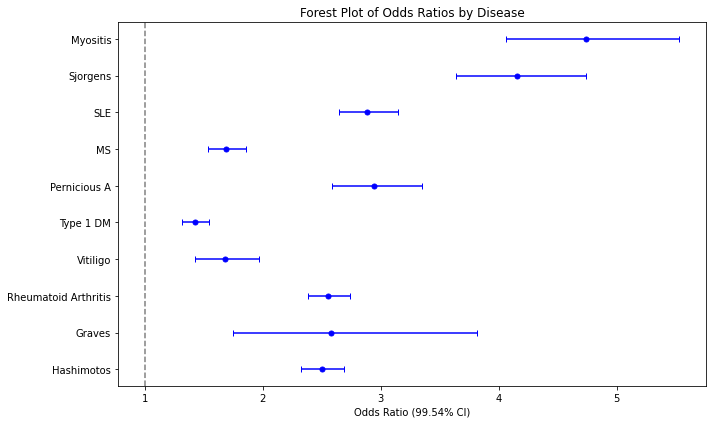

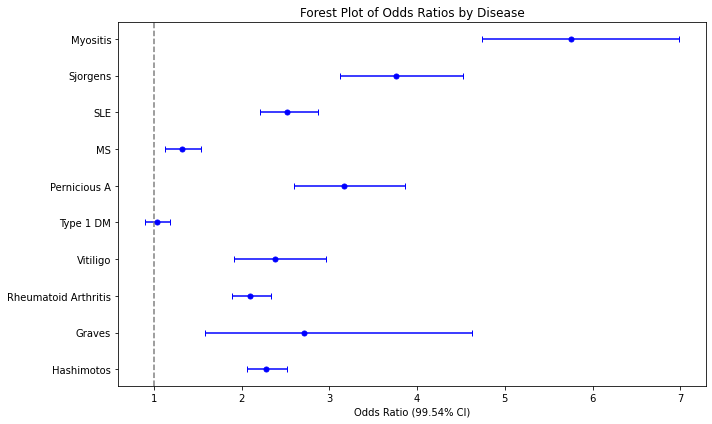

In [55]:
import matplotlib.pyplot as plt
def create_forest_plot_for_year(data, year):
    subset = data[data['Year'] == year]
    
    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the data
    ax.errorbar(subset['Odds Ratio'], subset.index + 1, xerr=[subset['Odds Ratio'] - subset['95% CI (Low)'], subset['95% CI (High)'] - subset['Odds Ratio']],
                fmt='o', markersize=5, capsize=3, color='blue')
    
    # Label diseases on the y-axis
    ax.set_yticks(subset.index + 1)
    ax.set_yticklabels(subset['Disease'])
    
    # Additional plot settings
    ax.axvline(1, color='gray', linestyle='--')
    ax.set_xlabel('Odds Ratio (99.54% CI)')
    ax.set_title(f"Forest Plot of Odds Ratios by Disease")
    plt.tight_layout()

# Create forest plots for each year
for year in results_df['Year'].unique():
    create_forest_plot_for_year(results_df, year)

In [57]:
#calculate OR/CI for all autoimmune diseases in CCAE 1 and 3 year cohorts 

results_df = pd.DataFrame(columns=['Year', 'Disease', 'Odds Ratio', '95% CI (Low)', '95% CI (High)', '95% CI (Low) Bonferroni', '95% CI (High) Bonferroni', 'P-value'])

for expanded_data in data:
    endo_subject_ids = expanded_data['endo_subject_id'].unique()
    comp_subject_ids = expanded_data['comp_subject_id'].unique()
    endo_subject_ids_set = set(endo_subject_ids)
    comp_subject_ids_set = set(comp_subject_ids)

    unique_ids = endo_subject_ids_set.union(comp_subject_ids_set)
    unique_ids_list = list(unique_ids)
    all_dis_df = autoimmune_data
    new_df_all = pd.DataFrame(unique_ids_list, columns=['subject_id'])
    new_df_all['endo'] = 0
    new_df_all['any_dis'] = 0

    endo_ids = expanded_data['endo_subject_id'].unique()
    new_df_all.loc[new_df_all['subject_id'].isin(endo_ids), 'endo'] = 1

    immune_start_date_map = all_dis_df.groupby('subject_id')['cohort_start_date'].min().to_dict()
    endo_visit_date_map = expanded_data.set_index('endo_subject_id')['endo_visit_date'].to_dict()

    new_df_all['dis_start_date'] = new_df_all['subject_id'].map(immune_start_date_map)
    new_df_all['endo_visit_date'] = new_df_all['subject_id'].map(endo_visit_date_map)
    all_dis_ids = all_dis_df['subject_id'].unique()

    new_df_all['days_difference'] = (pd.to_datetime(new_df_all['dis_start_date']) - pd.to_datetime(new_df_all['endo_visit_date'])).dt.days

    is_any_dis_without_endo_or_within_2_years = (
        (~new_df_all['endo'].astype(bool) & new_df_all['subject_id'].isin(all_dis_ids)) | 
        (new_df_all['endo'].astype(bool) & new_df_all['subject_id'].isin(all_dis_ids) & (new_df_all['days_difference'].abs() <= 2*365))
    )

    new_df_all.loc[is_any_dis_without_endo_or_within_2_years, 'any_dis'] = 1

    contingency_table_all = pd.crosstab(new_df_all['endo'], new_df_all['any_dis'])
    chi2, p, dof, expected = chi2_contingency(contingency_table_all)
    oddsratio_all, pvalue_all = scipy.stats.fisher_exact(contingency_table_all)

    a, b, c, d = contingency_table_all.iloc[0, 0], contingency_table_all.iloc[0, 1], contingency_table_all.iloc[1, 0], contingency_table_all.iloc[1, 1]
    se_log_or = np.sqrt((1/a) + (1/b) + (1/c) + (1/d))
    ci_log_up = np.log(oddsratio_all) + 1.96 * se_log_or
    ci_log_lo = np.log(oddsratio_all) - 1.96 * se_log_or
    ci_log_up_bf = np.log(oddsratio_all) + 2.8376 * se_log_or
    ci_log_lo_bf = np.log(oddsratio_all) - 2.8376 * se_log_or

    ci_or_all = np.exp(ci_log_up)
    ci_or_lo_all = np.exp(ci_log_lo)

    ci_or_bf = np.exp(ci_log_up_bf)
    ci_or_lo_bf = np.exp(ci_log_lo_bf)

    # Append results to the results_df for all autoimmune diseases
    results_df = results_df.append({
        'Year': year,
        'Disease': 'All Autoimmune Diseases',
        'Odds Ratio': oddsratio_all,
        '95% CI (Low)': ci_or_lo_all,
        '95% CI (High)': ci_or_all,
        '95% CI (Low) Bonferroni': ci_or_lo_bf,
        '95% CI (High) Bonferroni': ci_or_bf,
        'P-value':  "{:.2e}".format(pvalue)
    }, ignore_index=True)

    year += 1 

results_df


,Year,Disease,Odds Ratio,95% CI (Low),95% CI (High),95% CI (Low) Bonferroni,95% CI (High) Bonferroni,P-value
0,4,All Autoimmune Diseases,2.247939,2.174782,2.323557,2.142802,2.358234,4.26e-70
1,5,All Autoimmune Diseases,1.981279,1.884904,2.082582,1.843284,2.129605,4.26e-70


### MDCD Analysis

In [80]:
#read in mdcd data 
import pandas as pd

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/demographic queries/mdcd_1yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_1y = pd.read_pickle(file_path)

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/demographic queries/mdcd_3yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_3y = pd.read_pickle(file_path)

file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/matches/mdcd_10yr_matches.pkl'

# Read the pickle file into a pandas DataFrame
df_10y = pd.read_pickle(file_path)

In [81]:
# Convert the series of tuples into dataframes
data_list = df_1y['endo_subject_id'].tolist()

expanded_data_1 = pd.DataFrame.from_records(data_list, columns=[
    'endo_subject_id', 'endo_birth_year', 'endo_visit_date', 
    'comp_subject_id', 'comp_birth_year', 'comp_visit_date', 'score'
])
expanded_data_1 = expanded_data_1.drop_duplicates(subset=['comp_subject_id'])

# Convert the series of tuples into a list
data_list = df_3y['endo_subject_id'].tolist()

expanded_data_3 = pd.DataFrame.from_records(data_list, columns=[
    'endo_subject_id', 'endo_birth_year', 'endo_visit_date', 
    'comp_subject_id', 'comp_birth_year', 'comp_visit_date', 'score'
])
expanded_data_3 = expanded_data_3.drop_duplicates(subset=['comp_subject_id'])

data = [expanded_data_1, expanded_data_3]

In [82]:
expanded_data_3

,endo_subject_id,endo_birth_year,endo_visit_date,comp_subject_id,comp_birth_year,comp_visit_date,score
0,20000033823,1980,2013-06-21,20016602399,1980,2013-06-21,1
1,20000033823,1980,2013-06-21,20021469590,1980,2013-06-21,2
2,20000033823,1980,2013-06-21,20026912489,1980,2013-06-21,3
3,20000033823,1980,2013-06-21,20029612666,1980,2013-06-21,4
4,20000126418,1978,2016-10-27,20001658919,1978,2016-10-27,1
...,...,...,...,...,...,...,...
65328,20041756412,1971,2017-11-02,20039463889,1971,2017-11-02,4
65329,20041770947,1994,2017-11-02,20038604535,1994,2017-11-02,1
65330,20041770947,1994,2017-11-02,20038010313,1994,2017-11-02,2
65331,20041770947,1994,2017-11-02,20039286678,1994,2017-11-02,3


In [83]:
print(expanded_data_1.shape)
print(expanded_data_3['comp_subject_id'].nunique())
print(expanded_data_3['endo_subject_id'].nunique())

(141130, 7)
62263
16105


In [84]:
file_path = '/Users/maryamaziz/Desktop/CUIMC_Research/matches/autoimmune_cohorts_mdcd.pkl'

# Read the pickle file into a pandas DataFrame
df = pd.read_pickle(file_path)

df.head()

,0
0,"[IMMUNE3, 20009299627, 2009-12-21, 2010-12-31]"
1,"[IMMUNE3, 20033541871, 2014-10-28, 2017-12-31]"
2,"[IMMUNE3, 20025730928, 2009-01-26, 2017-12-31]"
3,"[IMMUNE3, 20039439944, 2016-06-22, 2017-12-31]"
4,"[IMMUNE3, 20041096533, 2013-01-24, 2014-06-30]"


In [85]:
data_list = df[0].tolist()

autoimmune_data = pd.DataFrame.from_records(data_list, columns=[
    'cohort_definition_id', 'subject_id', 'cohort_start_date', 
    'cohort_end_date'
])

autoimmune_data.head()

,cohort_definition_id,subject_id,cohort_start_date,cohort_end_date
0,IMMUNE3,20009299627,2009-12-21,2010-12-31
1,IMMUNE3,20033541871,2014-10-28,2017-12-31
2,IMMUNE3,20025730928,2009-01-26,2017-12-31
3,IMMUNE3,20039439944,2016-06-22,2017-12-31
4,IMMUNE3,20041096533,2013-01-24,2014-06-30


In [87]:
# Initialize an empty dataframe to store the results
#calculate OR/CI for separately for all diseases in MDCD 1 and 3 year cohorts 
results_df = pd.DataFrame(columns=['Year', 'Disease', 'Odds Ratio', '95% CI (Low)', '95% CI (High)', '95% CI (Low) Bonferroni', '95% CI (High) Bonferroni', 'P-value'])

year = 1 
for expanded_data in data:
    endo_subject_ids = expanded_data['endo_subject_id'].unique()
    comp_subject_ids = expanded_data['comp_subject_id'].unique()
    endo_subject_ids_set = set(endo_subject_ids)
    comp_subject_ids_set = set(comp_subject_ids)

    unique_ids = endo_subject_ids_set.union(comp_subject_ids_set)
    unique_ids_list = list(unique_ids)

    for dis in list(disease_map.keys()): 
        dis_df = autoimmune_data[autoimmune_data['cohort_definition_id'] == dis]
        new_df = pd.DataFrame(unique_ids_list, columns=['subject_id'])
        new_df['endo'] = 0
        new_df['dis'] = 0

        endo_ids = expanded_data['endo_subject_id'].unique()
        new_df.loc[new_df['subject_id'].isin(endo_ids), 'endo'] = 1

        immune_start_date_map = dis_df.set_index('subject_id')['cohort_start_date'].to_dict()
        endo_visit_date_map = expanded_data.set_index('endo_subject_id')['endo_visit_date'].to_dict()

        new_df['dis_start_date'] = new_df['subject_id'].map(immune_start_date_map)
        new_df['endo_visit_date'] = new_df['subject_id'].map(endo_visit_date_map)
        dis_ids = dis_df['subject_id'].unique()
        
        new_df['days_difference'] = (pd.to_datetime(new_df['dis_start_date']) - pd.to_datetime(new_df['endo_visit_date'])).dt.days

        is_dis_without_endo_or_within_2_years = (
            (~new_df['endo'].astype(bool) & new_df['subject_id'].isin(dis_ids)) | 
            (new_df['endo'].astype(bool) & new_df['subject_id'].isin(dis_ids) & (new_df['days_difference'].abs() <= 2*365))
        )
        
        new_df.loc[is_dis_without_endo_or_within_2_years, 'dis'] = 1

        contingency_table = pd.crosstab(new_df['endo'],new_df['dis'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        oddsratio, pvalue = scipy.stats.fisher_exact(contingency_table)

        a, b, c, d = contingency_table.iloc[0, 0], contingency_table.iloc[0, 1], contingency_table.iloc[1, 0], contingency_table.iloc[1, 1]
        se_log_or = np.sqrt((1/a) + (1/b) + (1/c) + (1/d))
        ci_log_up = np.log(oddsratio) + 1.96 * se_log_or
        ci_log_lo = np.log(oddsratio) - 1.96* se_log_or
        ci_log_up_bf = np.log(oddsratio) + 2.8376 * se_log_or
        ci_log_lo_bf = np.log(oddsratio) - 2.8376 * se_log_or

        ci_or = np.exp(ci_log_up)
        ci_or_lo = np.exp(ci_log_lo)

        ci_or_bf = np.exp(ci_log_up_bf)
        ci_or_lo_bf = np.exp(ci_log_lo_bf)

        # Append results to the results_df
        results_df = results_df.append({
            'Year': year,
            'Disease': disease_map[dis],
            'Odds Ratio': oddsratio,
            '95% CI (Low)': ci_or_lo,
            '95% CI (High)': ci_or,
            '95% CI (Low) Bonferroni': ci_or_lo_bf,
            '95% CI (High) Bonferroni': ci_or_bf,
            'P-value': "{:.2e}".format(pvalue)
        }, ignore_index=True)
    year += 1 

results_df

,Year,Disease,Odds Ratio,95% CI (Low),95% CI (High),95% CI (Low) Bonferroni,95% CI (High) Bonferroni,P-value
0,1,Hashimotos,3.148493,2.325596,4.262567,2.030598,4.881819,9.47e-13
1,1,Graves,2.348216,1.065531,5.175,0.748012,7.371697,4.92e-02
2,1,Rheumatoid Arthritis,4.139567,3.647203,4.6984,3.446161,4.972495,2.34e-101
3,1,Vitiligo,2.227162,1.438105,3.449158,1.182319,4.19536,5.16e-04
4,1,Type 1 DM,2.224196,1.990218,2.48568,1.893593,2.612519,1.72e-41
5,1,Pernicious A,2.720518,2.043606,3.621647,1.797883,4.116629,6.14e-11
6,1,MS,2.447014,2.056921,2.911087,1.903043,3.146475,5.09e-22
7,1,SLE,3.825397,3.310521,4.420351,3.103031,4.715925,2.30e-69
8,1,Sjorgens,5.990216,4.18984,8.564212,3.570144,10.050766,7.05e-23
9,1,Myositis,7.139955,4.843822,10.524531,4.071348,12.521396,2.81e-24


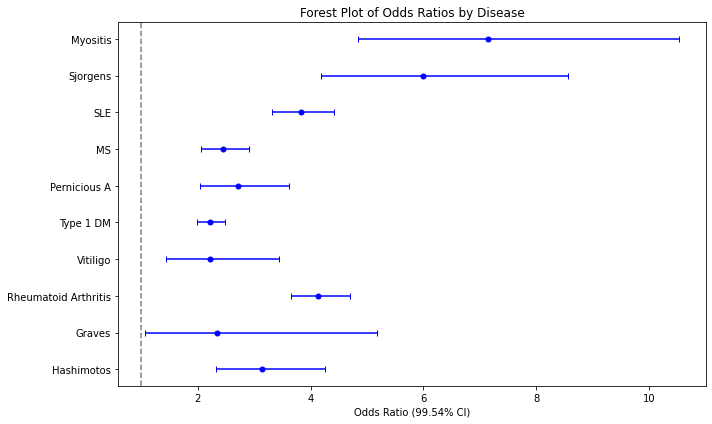

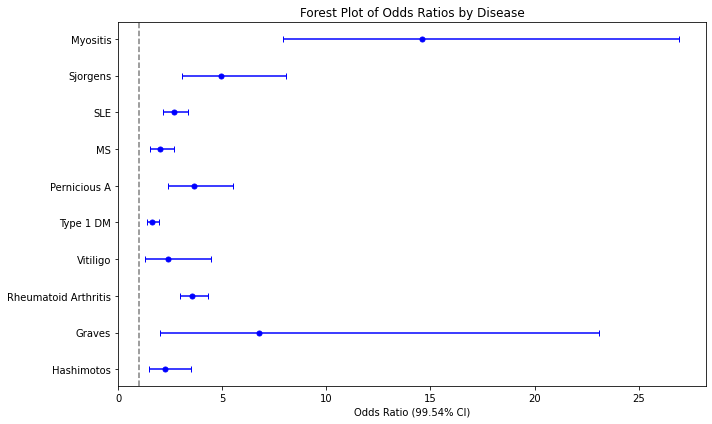

In [88]:
import matplotlib.pyplot as plt
def create_forest_plot_for_year(data, year):
    subset = data[data['Year'] == year]
    
    # Initialize figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the data
    ax.errorbar(subset['Odds Ratio'], subset.index + 1, xerr=[subset['Odds Ratio'] - subset['95% CI (Low)'], subset['95% CI (High)'] - subset['Odds Ratio']],
                fmt='o', markersize=5, capsize=3, color='blue')
    
    # Label diseases on the y-axis
    ax.set_yticks(subset.index + 1)
    ax.set_yticklabels(subset['Disease'])
    
    # Additional plot settings
    ax.axvline(1, color='gray', linestyle='--')
    ax.set_xlabel('Odds Ratio (99.54% CI)')
    ax.set_title(f"Forest Plot of Odds Ratios by Disease")
    plt.tight_layout()

# Create forest plots for each year
for year in results_df['Year'].unique():
    create_forest_plot_for_year(results_df, year)

In [89]:
#calculate OR/CI for all autoimmune diseases in MDCD 1 and 3 year cohorts 

year = 1
results_df = pd.DataFrame(columns=['Year', 'Disease', 'Odds Ratio', '95% CI (Low)', '95% CI (High)', '95% CI (Low) Bonferroni', '95% CI (High) Bonferroni', 'P-value'])
for expanded_data in data:
    endo_subject_ids = expanded_data['endo_subject_id'].unique()
    comp_subject_ids = expanded_data['comp_subject_id'].unique()
    endo_subject_ids_set = set(endo_subject_ids)
    comp_subject_ids_set = set(comp_subject_ids)

    unique_ids = endo_subject_ids_set.union(comp_subject_ids_set)
    unique_ids_list = list(unique_ids)
    all_dis_df = autoimmune_data
    new_df_all = pd.DataFrame(unique_ids_list, columns=['subject_id'])
    new_df_all['endo'] = 0
    new_df_all['any_dis'] = 0

    endo_ids = expanded_data['endo_subject_id'].unique()
    new_df_all.loc[new_df_all['subject_id'].isin(endo_ids), 'endo'] = 1

    immune_start_date_map = all_dis_df.groupby('subject_id')['cohort_start_date'].min().to_dict()
    endo_visit_date_map = expanded_data.set_index('endo_subject_id')['endo_visit_date'].to_dict()

    new_df_all['dis_start_date'] = new_df_all['subject_id'].map(immune_start_date_map)
    new_df_all['endo_visit_date'] = new_df_all['subject_id'].map(endo_visit_date_map)
    all_dis_ids = all_dis_df['subject_id'].unique()

    new_df_all['days_difference'] = (pd.to_datetime(new_df_all['dis_start_date']) - pd.to_datetime(new_df_all['endo_visit_date'])).dt.days

    is_any_dis_without_endo_or_within_2_years = (
        (~new_df_all['endo'].astype(bool) & new_df_all['subject_id'].isin(all_dis_ids)) | 
        (new_df_all['endo'].astype(bool) & new_df_all['subject_id'].isin(all_dis_ids) & (new_df_all['days_difference'].abs() <= 2*365))
    )

    new_df_all.loc[is_any_dis_without_endo_or_within_2_years, 'any_dis'] = 1

    contingency_table_all = pd.crosstab(new_df_all['endo'], new_df_all['any_dis'])
    chi2, p, dof, expected = chi2_contingency(contingency_table_all)
    oddsratio_all, pvalue_all = scipy.stats.fisher_exact(contingency_table_all)

    a, b, c, d = contingency_table_all.iloc[0, 0], contingency_table_all.iloc[0, 1], contingency_table_all.iloc[1, 0], contingency_table_all.iloc[1, 1]
    se_log_or = np.sqrt((1/a) + (1/b) + (1/c) + (1/d))
    ci_log_up = np.log(oddsratio_all) + 1.96 * se_log_or
    ci_log_lo = np.log(oddsratio_all) - 1.96* se_log_or
    ci_log_up_bf = np.log(oddsratio_all) + 2.8376 * se_log_or
    ci_log_lo_bf = np.log(oddsratio_all) - 2.8376 * se_log_or

    ci_or_all = np.exp(ci_log_up)
    ci_or_lo_all = np.exp(ci_log_lo)

    ci_or_bf = np.exp(ci_log_up_bf)
    ci_or_lo_bf = np.exp(ci_log_lo_bf)

    # Append results to the results_df for all autoimmune diseases
    results_df = results_df.append({
        'Year': year,
        'Disease': 'All Autoimmune Diseases',
        'Odds Ratio': oddsratio_all,
        '95% CI (Low)': ci_or_lo_all,
        '95% CI (High)': ci_or_all,
        '95% CI (Low) Bonferroni': ci_or_lo_bf,
        '95% CI (High) Bonferroni': ci_or_bf,
        'P-value': "{:.2e}".format(pvalue_all)
    }, ignore_index=True)

    year += 1 

results_df

,Year,Disease,Odds Ratio,95% CI (Low),95% CI (High),95% CI (Low) Bonferroni,95% CI (High) Bonferroni,P-value
0,1,All Autoimmune Diseases,2.986663,2.801124,3.184492,2.721827,3.277268,1.32e-225
1,2,All Autoimmune Diseases,2.402702,2.176148,2.652841,2.081756,2.773128,8.25e-62
